<a href="https://colab.research.google.com/github/jenny005/Reinforcement-Learning-by-Sutton-Barto/blob/main/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5 : Monte Carlo Methods

In [98]:
# Example 5.1 : Blackjack

# 1. Environment Setup

import random
from collections import defaultdict

# Draw a card: 1–10 (4 of each), face cards = 10
def draw_card():
    return min(random.randint(1, 13), 10) # J is 11, Q is 12, K is 13, but all faces are set to 10

def draw_hand():
    return [draw_card(), draw_card()] # return a list like: Hand 1: [1, 10], Hand 2: [3, 9]

def usable_ace(hand):  # Checks if the player has at least one Ace. Normally, an Ace counts as 1
    return 1 in hand and sum(hand) + 10 <= 21  # If we add 10, the total<=21, we're effectively counting it as 11. Then the Aces is usable, return 1 means True.

def sum_hand(hand):
    total = sum(hand)
    if usable_ace(hand):
        return total + 10
    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player_hand, dealer_card):
    return (sum_hand(player_hand), dealer_card, usable_ace(player_hand))



In [99]:
# 2. Define Policy (Stick if sum>=20)

def policy(player_sum):
    return 0 if player_sum >= 20 else 1  # 0 = stick, 1 = hit


In [100]:
# 3. Simulate a full episode under that policy

def play_episode():
    player = draw_hand() # player is a list like: Hand 1: [1, 10], Hand 2: [3, 9]
    dealer = draw_hand() # dealer is a list like: Hand 1: [2, 5], Hand 2: [4, J]
    dealer_showing = dealer[0]

    episode = [] # initializes an empty list to store the full trajectory of a Blackjack episode
    state = get_state(player, dealer_showing) # state = (sum_hand(player_hand), dealer_card, usable_ace(player_hand))

    # Player's turn
    while True:
        player_sum = state[0] # state[0]=sum_hand(player_hand)
        action = policy(player_sum) # policy returns 0 = stick, 1 = hit
        episode.append((state, action))  # Store state and action
        if action == 0:
            break  # Stick
        player.append(draw_card()) # not break means hit, player continue to draw a card
        if is_bust(player):
            return episode, -1  # Player loses, episode = A sequence of (state, action, reward) triplets that describe the full game from start to end
        state = get_state(player, dealer_showing)

    # Dealer's turn
    while sum_hand(dealer) < 17: # Dealer's policy = Must hit if sum < 17
        dealer.append(draw_card())
    if is_bust(dealer):
        return episode, 1  # Player wins, episode=[(state1,action1,reward1),(state2,action2,reward2),...]

    # Compare final sums
    player_sum = sum_hand(player)
    dealer_sum = sum_hand(dealer)
    if player_sum > dealer_sum:
        return episode, 1  # Player wins
    elif player_sum < dealer_sum:
        return episode, -1 # Dealer wins
    else:
        return episode, 0  # Player and Dealer draw


In [101]:
# 4. First-Visit Monte Carlo Prediction

def mc_prediction(policy, num_episodes=500000):
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    for _ in range(num_episodes):
        episode, reward = play_episode()
        visited_states = set()

        for idx, (state, _) in enumerate(episode):
            if state not in visited_states:
                visited_states.add(state)
                returns_sum[state] += reward
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

    return V  # V is the player dict, key is state=(sum_hand(player_hand), dealer_card, usable_ace(player_hand)), value is ratio


In [102]:
# 5. Run the Monte Carlo Prediction

V = mc_prediction(policy, num_episodes=300000)

# Example: print value for state with player sum 20, dealer showing 10, usable ace
print("Value of (20, 10, True):", round(V.get((20, 10, True), 0), 3)) # Value of (20, 10, True): 0.443 = the estimated expected return from this state under your policy



Value of (20, 10, True): 0.447


In [103]:
# 6. Plot Player's value function
policy_dict = {}

for player_sum in range(12, 22):
    for dealer_card in range(1, 11):
        for usable in [False, True]:
            state = (player_sum, dealer_card, usable)
            policy_dict[state] = policy(player_sum)


In [104]:
import matplotlib.pyplot as plt

def plot_policy_with_values(policy_dict, V):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    action_labels = ['Hit', 'Stick']
    ace_labels = ['No Usable Ace', 'Usable Ace']
    colors = {1: 'cyan', 0: 'lime'}

    for row, action in enumerate([1, 0]):  # Top = Hit, Bottom = Stick
        for col, usable_ace in enumerate([False, True]):
            ax = axes[row][col]
            ax.set_facecolor('black')
            ax.set_title(f"{ace_labels[col]}", fontsize=14, color='white')

            for dealer in range(1, 11):
                for player in range(12, 22):
                    state = (player, dealer, usable_ace)
                    policy_action = policy_dict.get(state, 0)
                    value = V.get(state, 0.0)

                    # Only plot if this subplot matches the action
                    if policy_action == action:
                        display_text = f"{action}\n{value:.3f}"
                        ax.text(player - 12, dealer - 1, display_text,
                                ha='center', va='center',
                                color=colors[action],
                                fontsize=9, fontweight='bold')

            # Ticks and labels
            ax.set_xticks(range(10))
            ax.set_xticklabels(range(12, 22), color='white')
            ax.set_yticks(range(10))
            ax.set_yticklabels(['A'] + list(range(2, 11)), color='white')
            ax.set_xlim(-0.5, 9.5)
            ax.set_ylim(-0.5, 9.5)
            ax.invert_yaxis()
            ax.set_xlabel("Player Sum", color='white')
            ax.set_ylabel("Dealer Showing", color='white')
            for spine in ax.spines.values():
                spine.set_edgecolor('white')

            # Add row label (Hit/Stick)
            ax.text(-1.8, 4.5, action_labels[row],
                    color='white', fontsize=14, rotation=90,
                    va='center', ha='center')

    fig.patch.set_facecolor('black')
    plt.tight_layout()
    plt.show()

# Player sum=16, Dealer showing=10, the value function=-0.593, implies that you lose roughly 59% more often than you win — and your overall chance of losing is well over 70% in that state.

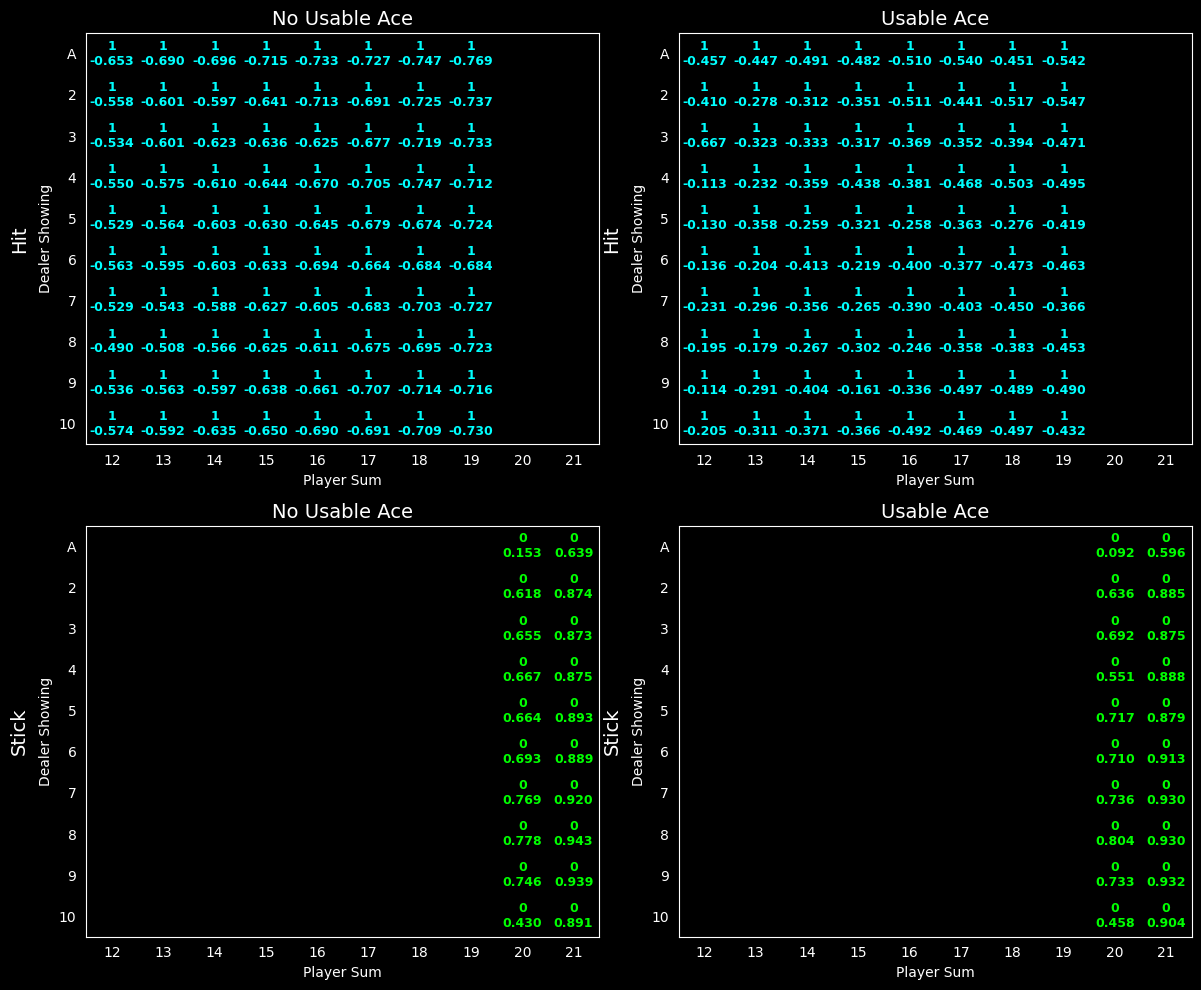

In [105]:
V = mc_prediction(policy=..., num_episodes=100000)
plot_policy_with_values(policy_dict, V) # player sum=20, dealer showing=10, no usable ace=0.42, usable ace=0.443,  means Ace flip to 11 have more value function than 1


In [106]:
import matplotlib.pyplot as plt

def plot_policy_value_2panel(policy_dict, V):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    titles = ['No Usable Ace', 'Usable Ace']
    colors = {1: 'cyan', 0: 'lime'}

    for col, usable_ace in enumerate([False, True]):
        ax = axes[col]
        ax.set_facecolor('black')
        ax.set_title(titles[col], fontsize=14, color='white')

        for dealer in range(1, 11):
            for player in range(12, 22):
                state = (player, dealer, usable_ace)
                action = policy_dict.get(state, 0)
                value = V.get(state, 0.0)
                display_text = f"{action}\n{value:.3f}"

                ax.text(player - 12, dealer - 1, display_text,
                        ha='center', va='center',
                        color=colors[action], fontsize=9, fontweight='bold')

        # Ticks and labels
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(12, 22), color='white')
        ax.set_yticks(range(10))
        ax.set_yticklabels(['A'] + list(range(2, 11)), color='white')
        ax.set_xlim(-0.5, 9.5)
        ax.set_ylim(-0.5, 9.5)
        ax.invert_yaxis()
        ax.set_xlabel("Player Sum", color='white')
        ax.set_ylabel("Dealer Showing", color='white')
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

    fig.patch.set_facecolor('black')
    plt.tight_layout()
    plt.show()


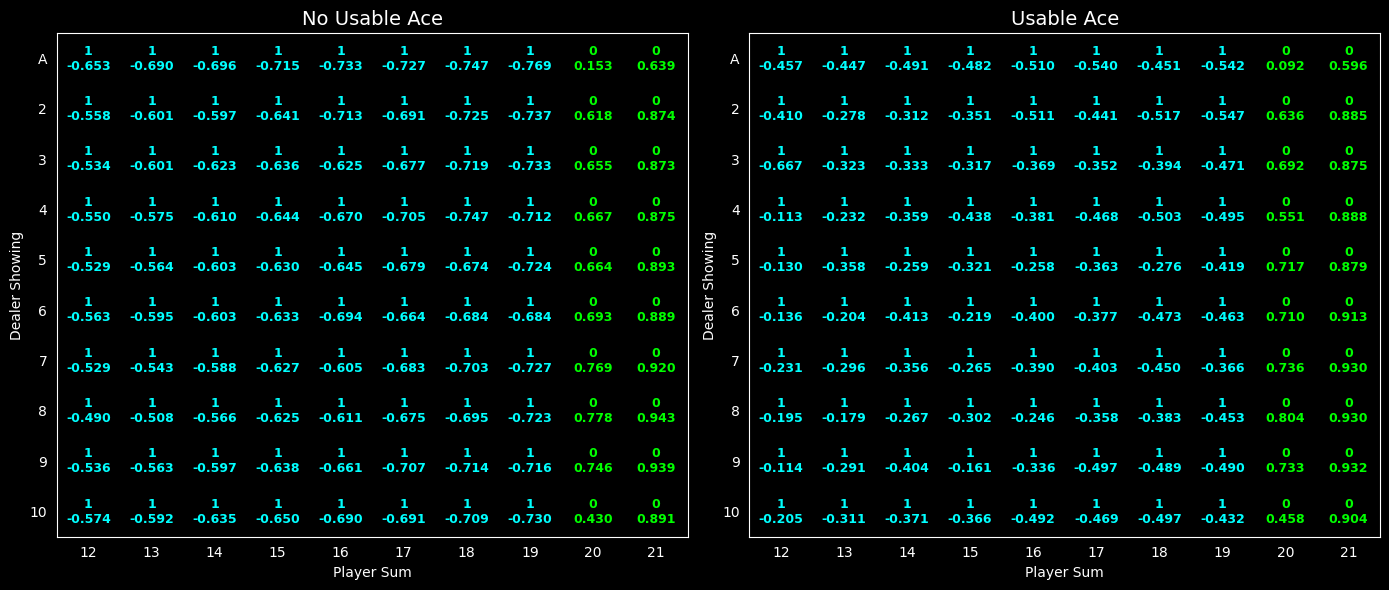

In [107]:
plot_policy_value_2panel(policy_dict, V)


In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_policy_value_3d(policy_dict, V):
    fig = plt.figure(figsize=(16, 6))

    ace_labels = ['No Usable Ace', 'Usable Ace']
    colors = {0: 'lime', 1: 'cyan'}

    for i, usable_ace in enumerate([False, True]):
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        ax.set_title(ace_labels[i], fontsize=14)

        X, Y, Z, C = [], [], [], []

        for player in range(12, 22):
            for dealer in range(1, 11):
                state = (player, dealer, usable_ace)
                value = V.get(state, 0.0)
                action = policy_dict.get(state, 0)

                X.append(player)
                Y.append(dealer)
                Z.append(value)
                C.append(colors[action])

        ax.scatter(X, Y, Z, c=C, s=60, edgecolors='k', depthshade=True)
        ax.set_xlabel("Player Sum")
        ax.set_ylabel("Dealer Showing")
        ax.set_zlabel("Value")
        ax.set_zlim(-1, 1)
        ax.view_init(elev=25, azim=225)

    plt.tight_layout()
    plt.show()


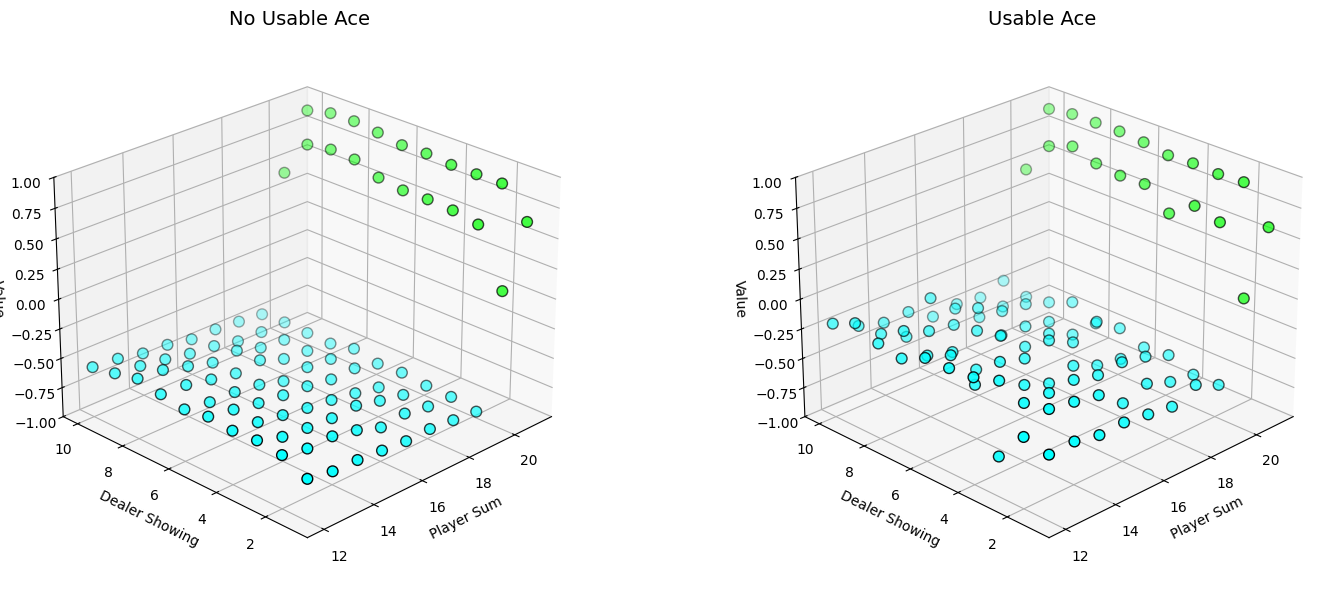

In [109]:
plot_policy_value_3d(policy_dict, V)


In [110]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_value_surface(V):
    fig = plt.figure(figsize=(14, 6))
    ace_labels = ['No Usable Ace', 'Usable Ace']

    x = np.arange(12, 22)
    y = np.arange(1, 11)
    X, Y = np.meshgrid(x, y)

    # Prepare surfaces for both ace cases
    surfaces = []
    for i, usable_ace in enumerate([False, True]):
        Z = np.zeros_like(X, dtype=float)
        for xi in range(len(x)):
            for yi in range(len(y)):
                state = (x[xi], y[yi], usable_ace)
                Z[yi, xi] = V.get(state, 0.0)

        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        ax.set_title(ace_labels[i], fontsize=14)
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.5)
        surfaces.append(surf)

        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        ax.set_zlim(-1, 1)
        ax.view_init(elev=30, azim=225)

    # Create a single colorbar on the right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(surfaces[0], cax=cbar_ax)

    plt.subplots_adjust(left=0.05, right=0.9, wspace=0.25)
    plt.show()


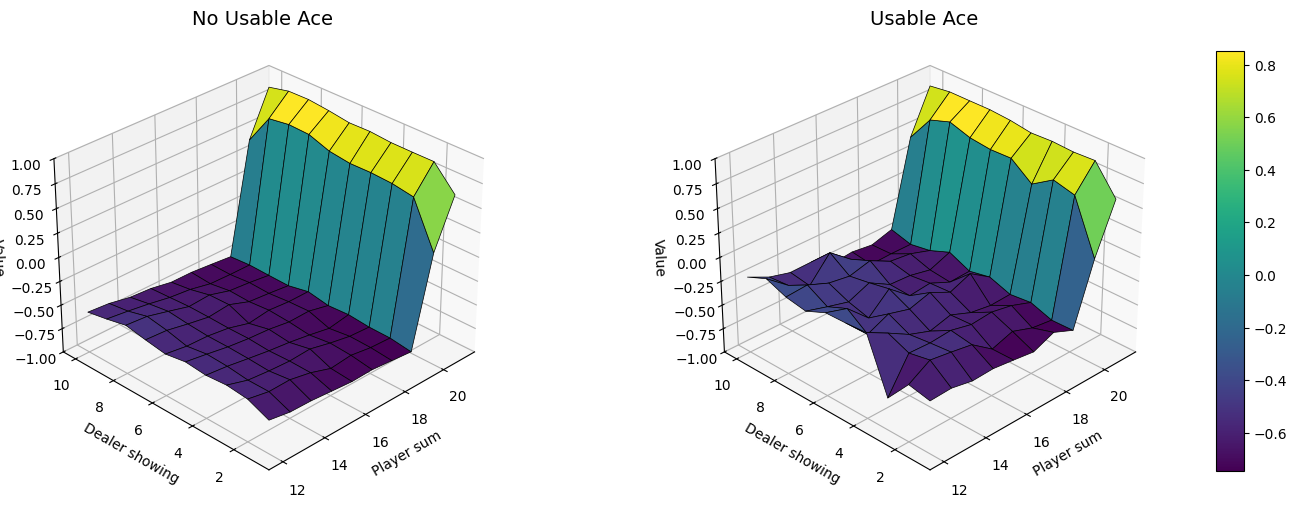

In [111]:
plot_value_surface(V)


In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_value_surface_4panel(V_10k, V_500k):
    fig = plt.figure(figsize=(16, 10))
    x = np.arange(12, 22)
    y = np.arange(1, 11)
    X, Y = np.meshgrid(x, y)

    value_sets = [
        (V_10k, "After 10,000 episodes"),
        (V_500k, "After 500,000 episodes")
    ]

    for col, (V, title) in enumerate(value_sets):
        for row, usable_ace in enumerate([True, False]):  # Top = usable, Bottom = no usable
            Z = np.zeros_like(X, dtype=float)
            for xi in range(len(x)):
                for yi in range(len(y)):
                    state = (x[xi], y[yi], usable_ace)
                    Z[yi, xi] = V.get(state, 0.0)

            ax = fig.add_subplot(2, 2, row * 2 + col + 1, projection='3d')
            ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.5)
            ax.set_zlim(-1, 1)
            ax.view_init(elev=30, azim=225)
            ax.set_xlabel('Player sum')
            ax.set_ylabel('Dealer showing')
            ax.set_zlabel('Value')

            if row == 0:
                ax.set_title(title, fontsize=14)
            if col == 0:
                ax.text2D(-0.15, 0.5, "Usable ace" if row == 0 else "No usable ace",
                          transform=ax.transAxes, fontsize=12, rotation=90,
                          verticalalignment='center')

    plt.tight_layout()
    plt.show()


In [113]:
V_10k = mc_prediction(policy=..., num_episodes=10000)
V_500k = mc_prediction(policy=..., num_episodes=500000)


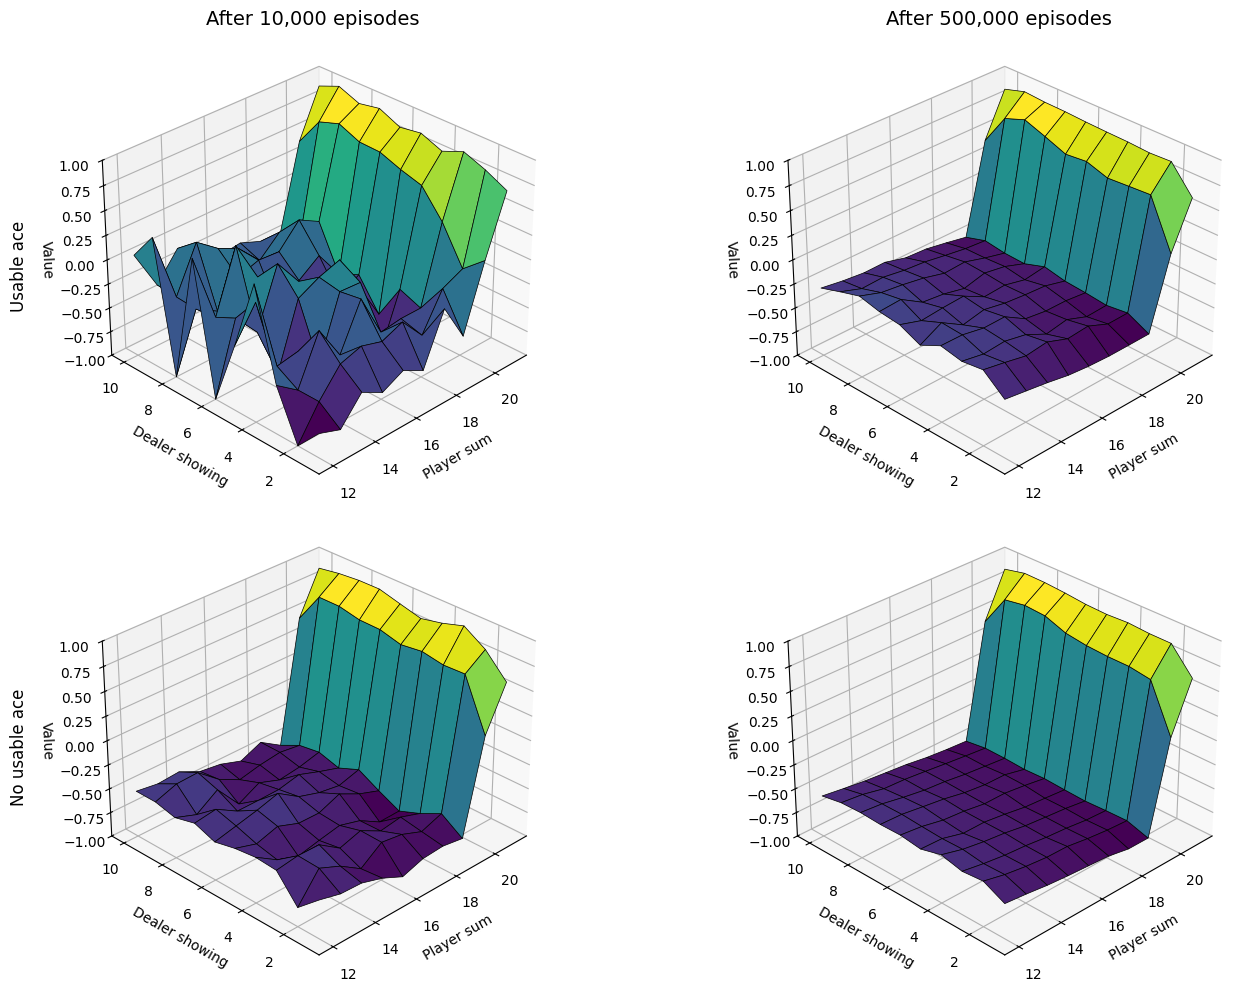

In [114]:
plot_value_surface_4panel(V_10k, V_500k)
